In this post I show one way that a time series can be symbolised on a map using a tiling-based approach.

Because the example data are monthly mean temperatures I've called this post 'mean temperature dials' but the idea is applicable to any sequential data. In this case, given monthly data, 12 slices make an analogy with clockfaces an obvious one, but there is no reason that this method couldn't be used with other numbers of time steps.

I'm sure there are other ways to make maps like these,^[Much derided pie charts come to mind.] but here I apply the tiling tools in my [`weavingspace` Python module](https://github.com/DOSull/weaving-space). The tiling pattern used in this example particularly makes sense for cyclical data.

Anyway, the data are as shown below.

In [146]:
#| label: python-imports
import geopandas as gpd

nz_temps = gpd.read_file("data/nz-avg-temps.gpkg")
print(nz_temps.head())

         Jan        Feb        Mar        Apr        May        Jun  \
0  19.505730  19.889172  19.054600  17.195982  15.189572  13.520309   
1  19.348455  19.754276  18.935886  17.079866  15.101235  13.446260   
2  19.381758  19.818325  19.018015  17.199263  15.224555  13.585258   
3  19.498827  19.888285  19.062172  17.150700  15.166919  13.491609   
4  19.519226  19.936918  19.119717  17.222164  15.210229  13.567471   

         Jul        Aug        Sep        Oct        Nov        Dec  \
0  12.600797  12.972336  13.583259  14.676813  16.179123  17.992401   
1  12.530506  12.867455  13.486817  14.565450  16.039982  17.834658   
2  12.671771  12.993229  13.603150  14.670104  16.126814  17.862686   
3  12.591331  12.931929  13.605309  14.708787  16.189005  18.011904   
4  12.650140  12.988663  13.651422  14.751802  16.205250  18.013773   

                                            geometry  
0  POLYGON ((19222240.002 -4101542.362, 19222240....  
1  POLYGON ((19231516.626 -4101542.3

The average temperatures have somewhere along the way been granted fake super high precision, so we round to one decimal place, and also get the overall minimum and maximum temperatures. This is so we can symbolise all the temperatures on the same colour scale in the final maps. We also need to retrieve a `months` list from the column names in the data.

In [147]:
#| label: round-numbers-and-mins-maxs
nz_temps.loc[:, months] = nz_temps.loc[:, months].round(1)
t_min = min(nz_temps.loc[:, months].min())
t_max = max(nz_temps.loc[:, months].max())
months = [m for m in nz_temps.columns if m != "geometry"]

### Make a _tileable unit_
Now we use some `weavingspace` uh... _magic_ to make a suitable 'clock face' _tileable unit_. A tileable unit is a small set of geometries that if repeated across a map area give the appearance of a tiled or woven pattern.

The starting point is a hexagon sliced radially into 12. The size of the unit is the distance between the faces of the hexagonal base tile, here set to 40km. We rotate the tile from its default orientation by 45&deg; to get a slice at 12 o'clock which we will associate later with the January temperatures. The rotation also means that the hexagonal lattice arrangement of the tiling we get won't have obvious east-west or north-south alignments, which I think makes for a more visually pleasing final map. The arrows on the plot below show the translations that will be used to copy and paste the tileable unit to create a tiled pattern.

::: {#fig-tile-unit group="tile-units"}

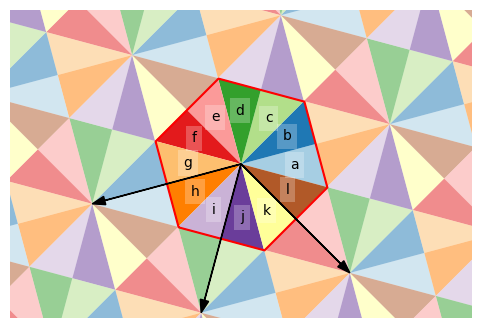

In [148]:
#| label: tile-unit
#| caption: "The basic hexagon 12-slice tile unit showing the tileable unit (outlined in red) and its translation vectors"
from weavingspace import TileUnit
import matplotlib.pyplot as plt

radius = 20_000
tile_unit = (
  TileUnit(tiling_type = "hex-slice", 
           n = 12, offset = 0,
           spacing = radius * 2)
  .transform_rotate(45)
)
ax = tile_unit.plot(r = 2, show_vectors = True, figsize = (6, 4))
ax.set_xlim((-60_000, 60_000))
ax.set_ylim((-40_000, 40_000))
ax.set_axis_off()

The basic 12-sliced hexagon tiling^[Also known as Laves tiling 4.6.12.]
:::

Note that the tile element IDs start at 'd' and go backwards through the alphabet, wrapping at 'a' followed by 'l'. This is important later for the mapping.

An enhancement of the final map in this application is to trim the tileable unit to a circle, including a slight gap between neighbouring circle. So we replace the `tiles.geometry` element of the tileable unit with a version clipped by a circle.

::: {#fig-clipped-tile-unit}

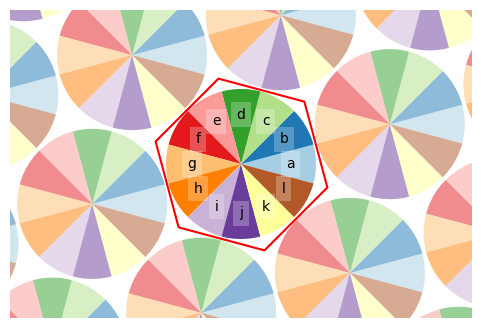

In [149]:
#| label: clipped-tile-unit
from shapely.geometry import Point

tile_unit.tiles.geometry = (
  tile_unit.tiles.geometry
  .clip(gpd.GeoSeries([Point(0, 0).buffer(radius - 500)],
                      crs = nz_temps.crs))
)
ax = tile_unit.plot(r = 2, figsize = (6, 4))
ax.set_xlim((-60_000, 60_000))
ax.set_ylim((-40_000, 40_000))
ax.set_axis_off()

The tile unit clipped by a circle to create 'dials'
:::

As you can, the clipped tileable unit will still be repeated in the same way due to the hexagonal basis of the tiling, but now with circular 12-slice 'pies'. Note here that we just clipped the simple 12 polygon `tiles.geometry` `GeoSeries` and `weavingspace` handles the process of copying this across a wider area to produce a different repeating pattern.

## Make a tiled map dataset
Now we make a `TiledMap` using `weavingspace`. This is essentially an overlay operation underneath, but internally `weavingspace` handles 'copying and pasting' the tileable unit across the map area to give a tiled pattern. All the particulars are stored in a `TiledMap` object, which has a `.map` attribute that contains all the needed data.

In [150]:
#| label: make-tiled-map
#| output: false
from weavingspace import TiledMap
from weavingspace import Tiling

tiled_map = Tiling(tile_unit, nz_temps).get_tiled_map(
  join_on_prototiles = True, retain_tileables = True)

/Users/david/miniconda3/envs/weavingspace/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


And here's what that `tiled_map.map` data looks like.

In [151]:
#| label: tiled-map-dataframe
print(f"{tiled_map.map.shape = }\n{tiled_map.map.head()}")

tiled_map.map.shape = (5724, 15)
  tile_id  prototile_id                                           geometry  \
0       a           153  POLYGON ((19864662.651 -4511236.578, 19883478....   
1       b           153  POLYGON ((19864662.651 -4511236.578, 19878451....   
2       c           153  POLYGON ((19864662.651 -4511236.578, 19869704....   
3       d           153  POLYGON ((19864662.651 -4511236.578, 19859621....   
4       e           153  POLYGON ((19864662.651 -4511236.578, 19850874....   

    Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec  
0  18.3  18.4  17.3  15.1  12.8  10.8  10.1  10.4  11.8  13.3  14.9  16.8  
1  18.3  18.4  17.3  15.1  12.8  10.8  10.1  10.4  11.8  13.3  14.9  16.8  
2  18.3  18.4  17.3  15.1  12.8  10.8  10.1  10.4  11.8  13.3  14.9  16.8  
3  18.3  18.4  17.3  15.1  12.8  10.8  10.1  10.4  11.8  13.3  14.9  16.8  
4  18.3  18.4  17.3  15.1  12.8  10.8  10.1  10.4  11.8  13.3  14.9  16.8  


We're only showing a few lines of the data table here, but it contains 5724 tiles (i.e., 477&times;12). 

The key attribute here in addition to the data sourced from the monthly temperatures is the `tile_id`, which we can use in mapping to split out the tiles into sets each of which we associate with a different variable. Here, we have 12 sets of tiles, and 12 variables, and we can make some maps.

## Making tiled multivariate maps
The `weavingspace.TiledMap` class has a `render()` method which makes a map with a single call, but since we want to apply exactly the same colour palette to every set of tiles, here it makes sense to split the tiles out manually by looping over them.^[I'll add this functionality to the to-do list for `weavingspace`. For now, doing it by hand is instructive.]

### A static map
To make a static map, we loop over the `tile_id` variable and `month` variable names, do a selection on the `map` dataset to pick out only those tiles with a given `tile_id`, and add those to a `geopandas.plot()` coloured by the value of the associated month's temperatures. Note the sequence of `tile_id` values required, as we saw in @fig-tile-unit and #fig-clip-by-circle that is the order of the `tile_id` value starting at 12 o'clock and going clockwise round the tile unit. Data limits on the colour ramp are specified with `vmin` and `vmax` and are the same for every set of tiles.

::: {#fig-static-map}

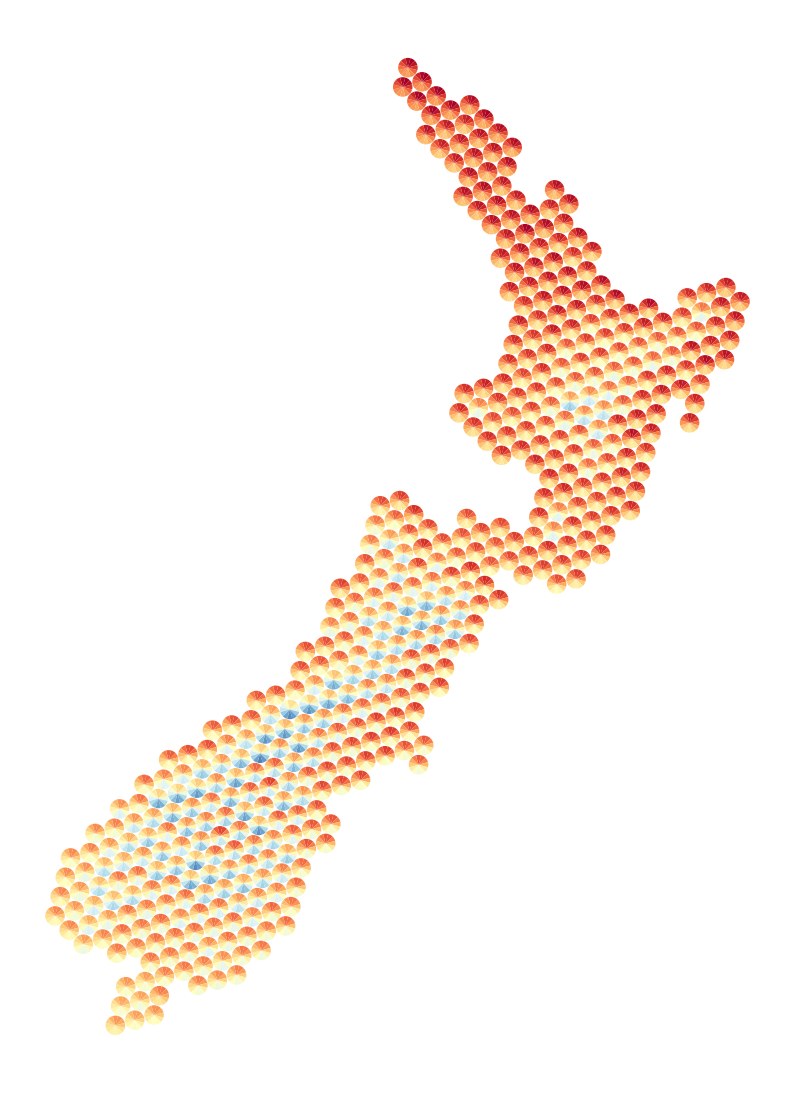

In [152]:
#| label: temperature-dials-static-map
#| fig-width: 10
#| fig-height: 14
fig = plt.figure(figsize = (10, 14))
ax = fig.add_subplot(111)
ax.set_axis_off()

for tile_id, month in zip(list("dcbalkjihgfe"), months):
  tiled_map.map.query("tile_id == @tile_id") \
  .plot(ax = ax, column = month, cmap = "RdYlBu_r",
        vmin = t_min, vmax = t_max, linewidth = 0)

A static map showing monthly average temperatures
::: 

### A web map
Given the scale of the data, it's useful to put them on a web map. The core of the code is essentially identical to the static map, but with slightly different parameter names needed to get a similar effect.

::: {#fig-web-map}

In [153]:
#| label: temperature-dials-web-map
import folium
from folium.plugins import Fullscreen
from folium import LayerControl

m = folium.Map(location = [-41, 173.5], tiles = "CartoDB Positron",
               zoom_start = 5, min_zoom = 4, max_zoom = 14)

for tile_id, month in zip(list("dcbalkjihgfe"), months):
  m = tiled_map.map.query("tile_id == @tile_id") \
  .explore(m = m, column = month, cmap = "RdYlBu_r",
            legend = False, vmin = t_min, vmax = t_max,
            tooltip = month, name = month,
            style_kwds = {"weight": 0, "fillOpacity": 0.8})
LayerControl(position = "topleft").add_to(m)
Fullscreen(position = "topright", force_separate_button = True).add_to(m)

m

&nbsp;
A web map of the monthly average temperatures
:::

If you zoom in on the map you can see which month corresponds to which pie slice and get a better feel for how the visualization works.

If this post has piqued your interest in this approach to mapping multivariate data, then you can find out more at the [`weavingspace` github repo](https://github.com/DOSull/weaving-space) or even experiment with making such maps using the [MapWeaver web app](https://dosull.github.io/mapweaver/app/).